### Predicting Depth with nonlinear Maximum Likelihood Method

In [57]:
# Install packages
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize

In [58]:
import os
current_path = os.getcwd()
os.chdir('j:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Main Dimensions Depth')
print(current_path)

j:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Main Dimensions Depth


In [128]:
# Prepare dataset
tabel = pd.read_excel('Main Dimensions Cleaned.xlsx')
tabel = tabel.dropna(subset=['Length Over All', 'Draught Design Deadweight', 'Depth', 'Beam Moulded']) #Remove missing values

# Show dataframe
print(tabel)

            Number                       Yard  Length Over All  \
0           DN3423                        NaN           128.80   
1     YN831 DN3365  Royal van Lent, Amsterdam           143.50   
2           DN3331                        NaN           136.00   
3          DN2631                         NaN           180.00   
4           DN3403                        NaN           131.00   
...            ...                        ...              ...   
1020       DN1653                         NaN            25.30   
1021       DN1611                         NaN             9.25   
1022       DN1589                         NaN            11.45   
1023       DN1602                         NaN             7.00   
1024        dn3590                        NaN            95.00   

      Draught Design Deadweight  Depth  Beam Moulded  
0                          6.00  11.55         22.50  
1                          5.95  11.35         20.00  
2                          5.83   9.93    

In [129]:
# Rename variables
Loa = tabel['Length Over All']
Tfull = tabel['Draught Design Deadweight']
D = tabel['Depth']
Bmld = tabel['Beam Moulded']

In [156]:
# Define variables for ML
x = tabel.loc[:, ~tabel.columns.isin(['Number', 'Yard', 'Depth'])]
y = D.values

# Column with ones for intercepts
X = np.column_stack((np.ones(x.shape[0]), x.values))

# Create log likelihood function
def log_L(params, Loa, Bmld, Tfull, y):
    omega, alpha, mu, tau, beta, gamma, sigma = params

    # Calculate predictions
    y_pred = omega + (alpha * Loa) + (mu * Loa**2) + (tau * Loa**3) + (beta * Bmld) + (gamma * Tfull)

    #Standardized residuals
    e_t = y - y_pred

    #Compute log_likelihood
    log_likelihood = (
        - 0.5 * np.sum(np.log(2*np.pi*(sigma**2)) + ((e_t)**2 / (sigma**2))))
    
    return -log_likelihood


# Initialiseer de parameters (omega, alpha, beta, gamma en sigma)
initial_params = np.array([0.2817, 0.0188, -0.0001, 0.0000006662, 0.2637, 0.5256, 0.3])

# Optimaliseer de log-likelihood functie
results = minimize(log_L, initial_params, args=(Loa, Bmld, Tfull, y), method='BFGS')

# Verkrijg de optimale parameters
optimal_params = results.x
omega_est, alpha_est, mu_est, tau_est, beta_est, gamma_est, sigma_est = optimal_params

# Print de resultaten
print("Geschatte parameters:")
print(f"omega = {omega_est:.4f}, alpha = {alpha_est:.4f}, mu = {mu_est:.4f}, tau = {tau_est:.4f}, beta = {beta_est:.4f}, gamma = {gamma_est:.4f}, sigma = {sigma_est:.4f}")
print("Maximale log-likelihood:", -results.fun)


Geschatte parameters:
omega = 0.2817, alpha = 0.0188, mu = -0.0001, tau = 0.0000, beta = 0.2637, gamma = 0.5256, sigma = 0.3000
Maximale log-likelihood: -230.00566930155912


In [157]:
# Bereken voorspelde waarden op basis van ML-model
predicted_values_ML = omega_est + (alpha_est * Loa) + (mu_est * Loa**2) + (tau_est * Loa**3) + (beta_est * Bmld) + (gamma_est * Tfull) 

# Controleer de residuen op normaliteit
residuals_ML = y - predicted_values_ML

# Voeg de voorspelde waarden toe aan de DataFrame
tabel['Predicted_Depth_ML'] = predicted_values_ML

# Toon de eerste paar rijen met de werkelijke en voorspelde diepte
print(tabel[['Depth', 'Predicted_Depth_ML']].head())

   Depth  Predicted_Depth_ML
0  11.55           10.977559
1  11.35           10.556120
2   9.93           10.285865
3  12.90           12.067732
4  11.10           10.460797


In [158]:
# Calculate MSE
mse = mean_squared_error(y, predicted_values_ML)
print(f"Mean Squared Error (MSE): {mse}")

# Bereken RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.09169740836122744
Root Mean Squared Error (RMSE): 0.3028157993916887


In [159]:
# Fill in the green numbers which correspond to the variable names in red before it:

Depth_prediction = omega_est +(alpha_est*95.65) + (mu_est*(95.65**2)) + (tau_est*(95.65**3)) + (beta_est*14) + (gamma_est*3.85)
print('Dit is de voorspelling volgens robuuste ML:', Depth_prediction)

Dit is de voorspelling volgens robuuste ML: 7.163113744461752


### Validatie plots voor NL polynomial degree 3 Loa

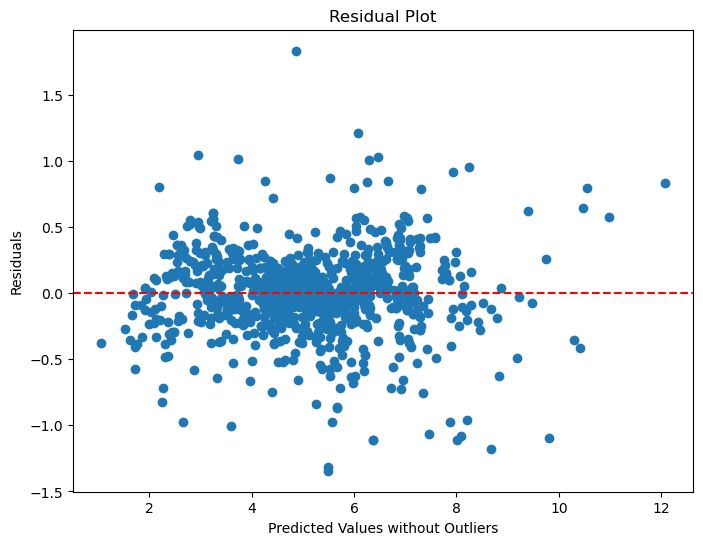

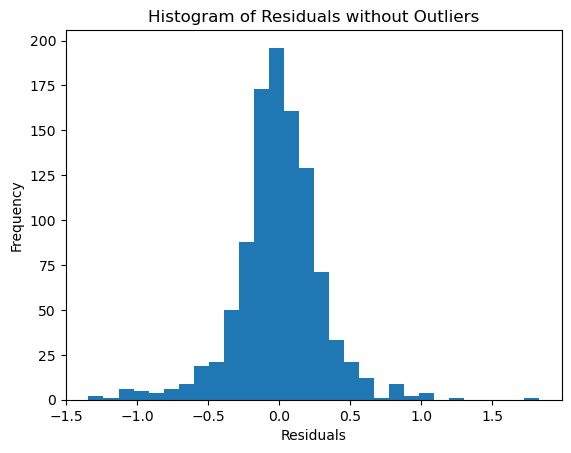

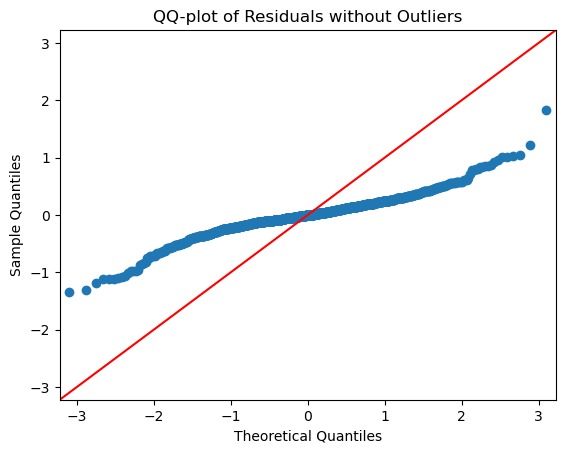

In [160]:
# Check residuals for normality
residuals_OLS_cleaned = y - predicted_values_ML

# Plot de residuals
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values_ML, residuals_OLS_cleaned)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values without Outliers')
plt.ylabel('Residuals')
plt.show()

#Lijkt niet helemaal willekeurig maar wel dichtbij! --> Welllicht outliers impact

# Check of residuals normaal verdeeld zijn
plt.hist(residuals_OLS_cleaned, bins=30)
plt.title('Histogram of Residuals without Outliers')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Install packages
import statsmodels.api as sm

# QQ-plot van residuals
sm.qqplot(residuals_OLS_cleaned, line='45')
plt.title('QQ-plot of Residuals without Outliers')
plt.show()

### Onderzoek polynoomgraden voor Loa tegen Depth

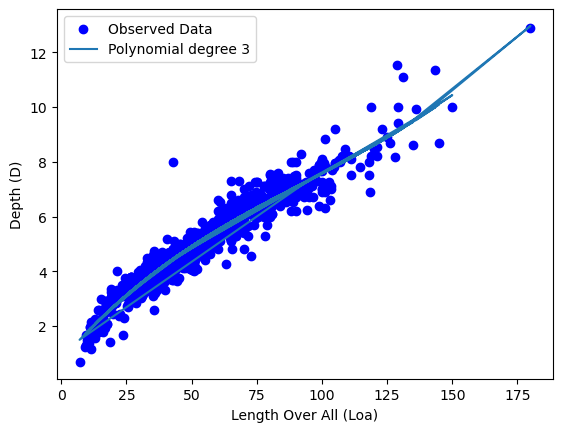

In [127]:
# PLot om trendlijnen toe te voegen
plt.scatter(Loa, D, color='blue', label='Observed Data')
for degree in range(3, 4):
    poly_coeffs = np.polyfit(Loa, D, degree)
    poly_fit = np.poly1d(poly_coeffs)
    plt.plot(Loa, poly_fit(Loa), label=f'Polynomial degree {degree}')
plt.xlabel('Length Over All (Loa)')
plt.ylabel('Depth (D)')
plt.legend()
plt.show()

In [90]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Data voorbereiden: test polynoomgraden voor Loa
for degree in range(1, 4):  # Test graden 1 t/m 3
    poly = PolynomialFeatures(degree, include_bias=False)
    Loa_poly = poly.fit_transform(Loa.values.reshape(-1, 1))

    # Combineer de polynomiale Loa met Bmld en Tfull als lineaire termen
    X = np.hstack([Loa_poly, Bmld.values.reshape(-1, 1), Tfull.values.reshape(-1, 1)])
    
    # Voer de regressie uit
    model = sm.OLS(D, sm.add_constant(X)).fit()
    
    # Bereken en print AIC, BIC en R²
    print(f'Degree {degree}')
    print(f'R²: {model.rsquared:.4f}')
    print(f'AIC: {model.aic:.4f}, BIC: {model.bic:.4f}\n')

Degree 1
R²: 0.9624
AIC: 479.5342, BIC: 499.2640

Degree 2
R²: 0.9625
AIC: 478.8401, BIC: 503.5024

Degree 3
R²: 0.9629
AIC: 470.7961, BIC: 500.3908



In [144]:
# Stel dat graad 2 het beste is
best_degree = 3
poly = PolynomialFeatures(best_degree, include_bias=False)
Loa_poly = poly.fit_transform(Loa.values.reshape(-1, 1))

# Combineer de polynomiale Loa met lineaire Bmld en Tfull
X_best = np.hstack([Loa_poly, Bmld.values.reshape(-1, 1), Tfull.values.reshape(-1, 1)])

# Voer de uiteindelijke regressie uit
final_model = sm.OLS(D, sm.add_constant(X_best)).fit()
print(final_model.summary())

# Bereken voorspellingen
D_pred = final_model.predict(sm.add_constant(X_best))
tabel['Predicted_Depth'] = D_pred

                            OLS Regression Results                            
Dep. Variable:                  Depth   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     5285.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:29:06   Log-Likelihood:                -229.40
No. Observations:                1025   AIC:                             470.8
Df Residuals:                    1019   BIC:                             500.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2817      0.065      4.317      0.0

### Onderzoek exponenten Loa

In [123]:
# Test verschillende machten voor Loa
exponents = [0.5, 0.99, 1, 1.1, 1.2, 1.5]  # Wortel, lineair, Loa^1.5, Loa^2

for exp in exponents:
    # Transformeer Loa met de huidige exponent
    Loa_transformed = Loa ** exp
    
    # Combineer getransformeerde Loa met de lineaire variabelen Bmld en Tfull
    X = np.column_stack((Loa_transformed, Bmld, Tfull))
    X = sm.add_constant(X)  # Voeg de intercept toe
    
    # Pas het model toe
    model = sm.OLS(D, X).fit()
    
    # Print de modelprestaties
    print(f'Exponent {exp}')
    print(f'R²: {model.rsquared:.4f}')
    print(f'AIC: {model.aic:.4f}, BIC: {model.bic:.4f}\n')


Exponent 0.5
R²: 0.9615
AIC: 502.7690, BIC: 522.4988

Exponent 0.99
R²: 0.9624
AIC: 479.6676, BIC: 499.3973

Exponent 1
R²: 0.9624
AIC: 479.5342, BIC: 499.2640

Exponent 1.1
R²: 0.9624
AIC: 478.7829, BIC: 498.5127

Exponent 1.2
R²: 0.9624
AIC: 478.8558, BIC: 498.5856

Exponent 1.5
R²: 0.9623
AIC: 481.4486, BIC: 501.1784



Conclusie = linear fit het beste in vergelijking met andere exponenten